The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


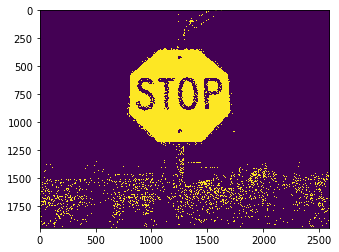

In [3]:
%load_ext autoreload
%autoreload 2
import cv2
import abc
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../src")
from classifier import SimpleHSVRedClassifier
import classifier

img = cv2.imread('../trainset/8.jpg')
img_ = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
clf = SimpleHSVRedClassifier()
res = clf.predict(img)
plt.imshow(res)
# plt.imshow(img)
res_ = res.copy()
GOGO = '../trainset/8.jpg'

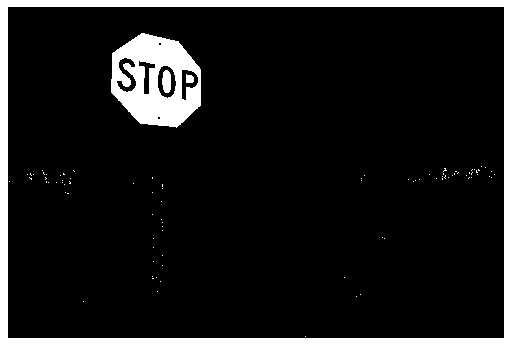

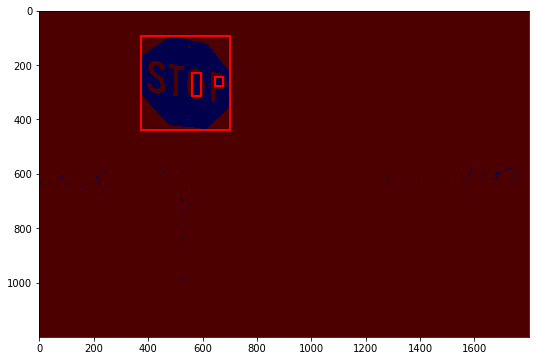

hexagon 6
Total Area:  6480.0 , Region Area:  87022.5
half octagon


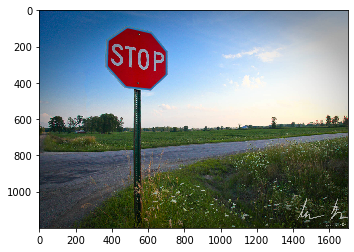

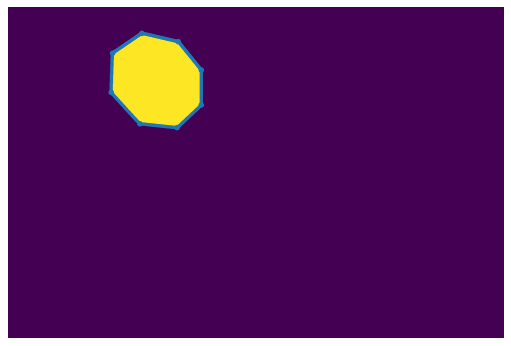

octagon 8
Total Area:  6480.0 , Region Area:  2270.5
half octagon


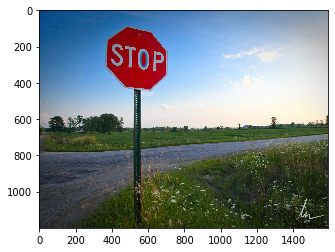

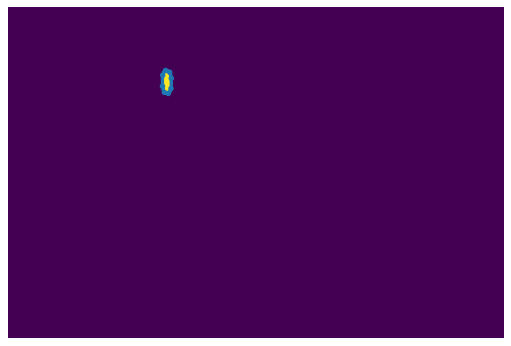

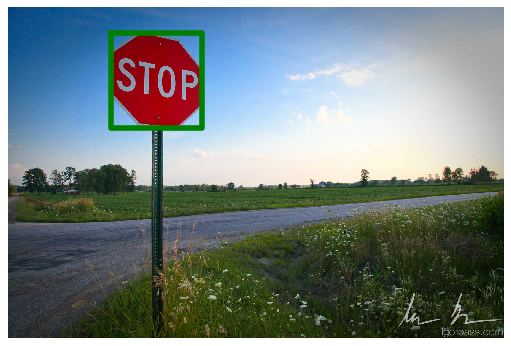

In [193]:
##### import math
from skimage.measure import label, regionprops, approximate_polygon
from skimage.color import label2rgb
import cv2
from classifier import SimpleHSVRedClassifier, GaussianNaiveBayes, KaryLogisticRegression
from detector import *
from image import build_histogram_equalizer

img = cv2.imread(GOGO)
img_area = img.shape[0] * img.shape[1]
HH, WW, _ = img.shape

#-------- histogram equalization ------------




img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
oimg = img.copy()

# img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
# f = build_histogram_equalizer(img[:, :, 0], 255)
# img[:, :, 0] = f(img[:, :, 0])
# img = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)

# img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
# img[:, :, 1] = np.clip((img[:, :, 1].astype(float) * 2.0), a_min=0, a_max=255).astype(np.uint8)
# img[:, :, 2] = np.clip((img[:, :, 2].astype(float) * 1.9), a_min=0, a_max=255).astype(np.uint8)
# img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)


# -------------------------------------------


X = img.reshape(-1, 3)

#--------- Append YCrCb -------------
# imgycc = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
# imgycc = imgycc.reshape(-1, 3)
# X = np.hstack([X, imgycc])
# -----------------------------------

# --------- Append Bias -------------
# X = np.hstack([X, np.ones((X.shape[0], 1))])
# -----------------------------------

clf = GaussianNaiveBayes()
clf.load('../model/gnb_test.pic')
# clf = KaryLogisticRegression()
# clf.load('../model/klogreg_300000.pic')
# clf = SimpleHSVRedClassifier()

imgshape = img.shape
res = clf.predict(X).reshape(img.shape[:2])
res = (res == 0).astype(int)
# plt.imshow(res)
# plt.imshow(img)
res_ = res.copy()
        
label_image = label(res, connectivity=1)
image_label_overlay = label2rgb(res, image=res)

fig, ax = plt.subplots(1, figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
ax.set_axis_off()
plt.imshow(res * 255, cmap=plt.cm.gray)
plt.show()


# ----------------------------------
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
for region in Region.find(res):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
plt.show()
# ----------------------------------

bbox = set()
for props in Region.find(res, oimg):
    if props.area >= 100:
        
        minr, minc, maxr, maxc = props.bbox
        lr = maxr - minr
        lc = maxc - minc
        
#         if max(lc, lr) - min(lc, lr) > 1.5 * min(lc, lr):
#             break

        
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        
       
        cvx_img = np.zeros((HH, WW))
        cvx_img[minr:maxr, minc:maxc] = props.convex_image
        cnts = Contour.find(cvx_img)
        for contour in cnts:
            if contour.area > img_area * 0.001 and contour.area > region.bbox_area * 0.2:
                # if not (region.image[region.image != 0].sum() >
                #         contour.area * 0.4):
                #     return False

                approx_polygon = contour.approx_polygon()
                n_edges = approx_polygon.n_edges
                print(poly.shape_name, poly.n_edges)
                print('Total Area: ', img_area * 0.003, ', Region Area: ', contour.area)

                if 7 <= n_edges <= 10:
                    degs = approx_polygon.angles_deg * 2
                    continuous_degs_sums = [
                        sum(degs[i:i + 4]) for i in range(n_edges)
                    ]

                    n_valid_partial_octagon = sum([
                        160 < v % 360 < 200 or 160 < (v + 180) % 360 < 200
                        for v in continuous_degs_sums
                    ])
                    if (n_valid_partial_octagon >= 2 and n_edges <= 12) \
                        or (n_valid_partial_octagon >= 3 and n_edges <= 16):
                        print('half octagon')
                        bbox.add((bx, by))
                
                
                appr = contour.numpy[:, 0, :]
                plt.imshow(props.padded_original_image(1000))
                plt.plot(appr[:, 0], appr[:, 1])
                plt.show()
                
                fig, ax = plt.subplots(1, figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
                ax.set_axis_off()
                plt.imshow(cvx_img)
                poly = approx_polygon
                for i in range(poly.numpy.shape[0]):
                    rect = mpatches.Circle((poly.numpy[i, 0, 0], poly.numpy[i, 0, 1]), 10, fill=True)
                    ax.add_patch(rect)
                plt.plot(appr[:, 0], appr[:, 1], linewidth=3)
                plt.show()
#                 plt.imshow(cvx_img)
#                 plt.show()
                

fig, ax = plt.subplots(1, figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
ax.set_axis_off()
plt.imshow(oimg)
for bx, by in list(bbox):
    plt.plot(bx, by, '-g', linewidth=5)
plt.show()